In [82]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [71]:
# wanneer google colab gebruiken, uit comments halen
# from google.colab import drive
# drive.mount('/content/drive')

In [83]:
# DATADIR = r"/content/drive/MyDrive/covers"  # Path naar data op google drive
# DATADIR = r"C:\covers\covers"  # Path naar data lokaal
DATADIR = '/mnt/c/covers/covers'  # Path naar data met WSL2

img_height, img_width = 224, 224
batch_size=8
# Larger batch size may provide some computational speed-up but requires more memory
# Smaller batch sizes may offer better generalization, but training might be slower

In [84]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATADIR,
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

Found 9863 files belonging to 2 classes.
Using 8384 files for training.


In [85]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATADIR,
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

Found 9863 files belonging to 2 classes.
Using 1479 files for validation.


In [86]:
from collections import Counter
import tensorflow as tf

# Counting the labels
label_counts = Counter()
for _, labels in train_ds:
    label_counts.update(labels.numpy())

# Printing out the count of each label
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")


class_weights = {0: 1.818, 1: 4.0}


print(class_weights)

Label 0: 5735 samples
Label 1: 2649 samples
{0: 1.818, 1: 4.0}


In [87]:
# Define the ModuleWrapper class
class ModuleWrapper(tf.keras.layers.Layer):
    def __init__(self, module, method_name, **kwargs):
        super(ModuleWrapper, self).__init__(**kwargs)
        self.module = module
        self.method_name = method_name

    def call(self, inputs):
        pass

    def get_config(self):
        config = super(ModuleWrapper, self).get_config()
        config.update({
            'module': self.module,
            'method_name': self.method_name
        })
        return config

In [88]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2), 
    layers.RandomBrightness(0.2),
])

In [89]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

In [90]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(img_height, img_width, 3),
    pooling='avg',
    classes=1,
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dropout(0.2))
resnet_model.add(layers.Dense(1, activation='sigmoid'))

module_wrapper = ModuleWrapper(pretrained_model, "call")
module_wrapper.build((None, img_height, img_width, 3))

# pretrained_model.summary()

In [91]:
resnet_model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
epochs = 80

history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)


Epoch 1/80
1048/1048 [==============================] - 39s 33ms/step - loss: 1.4563 - accuracy: 0.7184 - val_loss: 0.5325 - val_accuracy: 0.7417
Epoch 2/80
1048/1048 [==============================] - 33s 31ms/step - loss: 1.2180 - accuracy: 0.7686 - val_loss: 0.5120 - val_accuracy: 0.7525
Epoch 3/80
1048/1048 [==============================] - 34s 32ms/step - loss: 1.1295 - accuracy: 0.7969 - val_loss: 0.5349 - val_accuracy: 0.7390
Epoch 4/80
1048/1048 [==============================] - 33s 32ms/step - loss: 1.0563 - accuracy: 0.8081 - val_loss: 0.4914 - val_accuracy: 0.7721
Epoch 5/80
1048/1048 [==============================] - 34s 32ms/step - loss: 1.0035 - accuracy: 0.8189 - val_loss: 0.4893 - val_accuracy: 0.7634
Epoch 6/80
1048/1048 [==============================] - 33s 32ms/step - loss: 0.9585 - accuracy: 0.8366 - val_loss: 0.4390 - val_accuracy: 0.8107
Epoch 7/80
1048/1048 [==============================] - 34s 32ms/step - loss: 0.9007 - accuracy: 0.8505 - val_loss: 0.5009 -

In [95]:
# wanneer google colab gebruiken, dit path gebruiken
# resnet_model.save("/content/drive/MyDrive/covers_model/themis.keras") # google colab
# resnet_model.save(r"C:\OwnPorrima\themis_model_v5.keras") # local
resnet_model.save("/mnt/c/OwnPorrima/themis_model_v3.keras") # wsl2


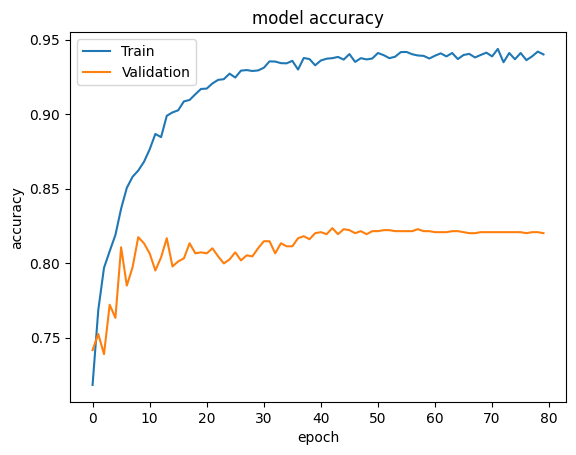

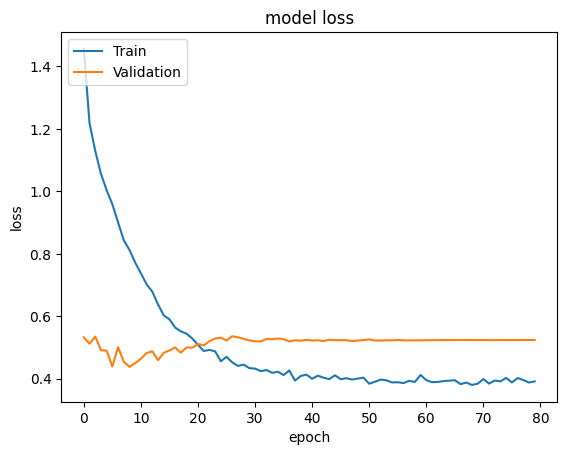

In [96]:
# evaluatie accuracy & loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [98]:
import cv2
import os
import numpy as np

# Load the model
# resnet_model = tf.keras.models.load_model(r"C:\OwnPorrima\themis_model_v.keras") # local
resnet_model = tf.keras.models.load_model("/mnt/c/OwnPorrima/themis_model_v3.keras") # wsl2

# TEST_DIR = r"C:\covers\testset" # local
TEST_DIR = "/mnt/c/covers/testset" # wsl2

CATEGORIES = ["goed", "slecht"]  # Labels / Subfolders

img_height, img_width = 224, 224 

predictions = []

for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_width, img_height))
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        prediction = resnet_model.predict(img)
        print(prediction)

        predicted_category = "goed" if prediction[0][0] <= 0.5 else "slecht"

        predictions.append((img_path, category, predicted_category))

for img_path, true_category, predicted_category in predictions:
    print(f"Image: {img_path}, True Category: {true_category}, Predicted Category: {predicted_category}")


1/1 [==============================] - 2s 2s/step
[[0.00339165]]
1/1 [==============================] - 0s 28ms/step
[[0.01541095]]
1/1 [==============================] - 0s 19ms/step
[[0.0247026]]
1/1 [==============================] - 0s 21ms/step
[[0.07281414]]
1/1 [==============================] - 0s 25ms/step
[[0.08406436]]
1/1 [==============================] - 0s 18ms/step
[[0.0013391]]
1/1 [==============================] - 0s 24ms/step
[[0.97645193]]
1/1 [==============================] - 0s 20ms/step
[[0.99997497]]
1/1 [==============================] - 0s 19ms/step
[[0.7486367]]
1/1 [==============================] - 0s 19ms/step
[[0.8152295]]
1/1 [==============================] - 0s 21ms/step
[[0.8857593]]
1/1 [==============================] - 0s 24ms/step
[[0.9908879]]
1/1 [==============================] - 0s 19ms/step
[[0.99675924]]
Image: /mnt/c/covers/testset/goed/isbn9780030653650.jpg, True Category: goed, Predicted Category: goed
Image: /mnt/c/covers/testset/goed/